Скачиваем данные

In [ ]:
!wget https://www.dropbox.com/s/u0l2fkkmtmjumbx/hpac_lower_tokenized.zip > null
!wget https://www.dropbox.com/s/aogtja9upycdqv4/hpac_splits.zip > null

!unzip /content/hpac_lower_tokenized.zip > null
!unzip /content/hpac_splits.zip > null

импортируем необходимые библиотеки

In [ ]:
import os
import string

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from gensim.utils import any2unicode
from torch.utils.data import DataLoader, Dataset
from gensim.models.fasttext import FastText
from torch import nn, relu, optim
from torch.nn import Conv1d, Linear
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short

Будем считывать данные из документов с помощью итератора. Загрузить все данные и токенизировать их сразу не представляется возможным из-за ограничений по RAM.

In [ ]:
class DataLoader:
    def __init__(self, dir):
        self.dir = dir
        self.filenames = [filename for filename in os.listdir(dir)]
        self.index = -1
        self.size = len(self.filenames)

    def __iter__(self):
        return self

    def __next__(self):
        self.index += 1
        if self.index % 3000 == 0:
          print(f"[{self.index}/{self.size}]")
        if self.index < self.size:
            with open(self.dir + self.filenames[self.index], 'r') as f:
              tokenized_text = strip_short(strip_punctuation(remove_stopwords(f.read()))).split()
            return tokenized_text
        self.index = -1
        raise StopIteration

Часть 1. Эксплоративный анализ

1) Найдите топ-1000 слов по частоте без учета стоп-слов.

2) Найдите топ-10 по частоте: имен, пар имя + фамилия, пар вида ''профессор'' + имя / фамилия.

In [ ]:
dataloader = DataLoader("/content/hpac_source/")

with open("/content/hp_names.txt", "r") as f:
  NAMES = f.read().split('\n')

мы используем `hp_names.txt` -- список имён всех персонажей из вселенной Гарри Поттера

In [ ]:
D = {}

names1 = {}
names2 = {}

for tokens in dataloader:
  for i in range(len(tokens)):
    if tokens[i] not in D.keys():
      D[tokens[i]] = 0
    D[tokens[i]] += 1

    for name in NAMES:
      if tokens[i] in name:
        if name not in names1.keys():
          names1[name] = 0
        names1[name] += 1

    if tokens[i-1] == 'professor':
      token = tokens[i-1] + ' ' + tokens[i]
      if token not in names2.keys():
        names2[token] = 0
      names2[token] += 1

[0/36225]
[3000/36225]
[6000/36225]
[9000/36225]
[12000/36225]
[15000/36225]
[18000/36225]
[21000/36225]
[24000/36225]
[27000/36225]
[30000/36225]
[33000/36225]
[36000/36225]


топ 1000 слов по встречаемости

In [ ]:
top_1000 = sorted(list(D.items()), key= lambda x: x[1], reverse=True)[:1000]
top_1000

[('harry', 4000516),
 ('said', 2262365),
 ('hermione', 1831475),
 ('draco', 1389987),
 ('like', 1275302),
 ('know', 1203944),
 ('eyes', 1033470),
 ('time', 1016960),
 ('ron', 906202),
 ('looked', 893446),
 ('asked', 826495),
 ('head', 737083),
 ('going', 718864),
 ('think', 716081),
 ('face', 657548),
 ('way', 656364),
 ('severus', 655654),
 ('room', 648484),
 ('hand', 639613),
 ('ginny', 639548),
 ('sirius', 630219),
 ('want', 613217),
 ('potter', 608426),
 ('thought', 608150),
 ('right', 603542),
 ('snape', 600492),
 ('away', 580725),
 ('look', 566544),
 ('knew', 524841),
 ('let', 513133),
 ('good', 510094),
 ('malfoy', 486352),
 ('wand', 482520),
 ('little', 481406),
 ('felt', 476097),
 ('dumbledore', 472845),
 ('turned', 472763),
 ('james', 468948),
 ('come', 461133),
 ('got', 451904),
 ('took', 436164),
 ('remus', 433776),
 ('lily', 423907),
 ('sure', 414026),
 ('looking', 412943),
 ('door', 408796),
 ('tell', 407274),
 ('dark', 407101),
 ('long', 400952),
 ('voice', 397147),
 ('v

In [ ]:
top_10 = sorted(list(names1.items()), key= lambda x: x[1], reverse=True)[:10]
top_10

[('harry potter', 4629024),
 ('hermione granger', 2295874),
 ('draco malfoy', 1879576),
 ('severus snape', 1317845),
 ('bloody baron', 1210250),
 ('ronald weasley', 1190823),
 ('james potter i', 1095258),
 ('luna lovegood', 1059119),
 ('lily j. potter', 1050145),
 ('sirius black', 1018610)]

In [ ]:
top_10 = sorted(list(names2.items()), key= lambda x: x[1], reverse=True)[:10]
top_10

[('professor snape', 46387),
 ('professor mcgonagall', 43248),
 ('professor dumbledore', 24576),
 ('professor lupin', 10338),
 ('professor flitwick', 9600),
 ('professor slughorn', 5941),
 ('professor sprout', 5807),
 ('professor harry', 5031),
 ('professor said', 4613),
 ('professor trelawney', 3203)]

In [ ]:
while True:
  pass

Часть 2. [2 балла] Модели представления слов

Обучите модель представления слов (word2vec, GloVe, fastText или любую другую) на материале корпуса HPAC.

Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели.

Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP (https://umap-learn.readthedocs.io).


In [ ]:
model = Word2Vec(dataloader)

[0/36225]
[3000/36225]
[6000/36225]
[9000/36225]
[12000/36225]
[15000/36225]
[18000/36225]
[21000/36225]
[24000/36225]
[27000/36225]
[30000/36225]
[33000/36225]
[36000/36225]
[0/36225]
[3000/36225]
[6000/36225]
[9000/36225]
[12000/36225]
[15000/36225]
[18000/36225]
[21000/36225]
[24000/36225]
[27000/36225]
[30000/36225]
[33000/36225]
[36000/36225]
[0/36225]
[3000/36225]
[6000/36225]
[9000/36225]
[12000/36225]
[15000/36225]
[18000/36225]
[21000/36225]
[24000/36225]
[27000/36225]
[30000/36225]
[33000/36225]
[36000/36225]
[0/36225]
[3000/36225]
[6000/36225]
[9000/36225]
[12000/36225]
[15000/36225]
[18000/36225]
[21000/36225]
[24000/36225]
[27000/36225]
[30000/36225]
[33000/36225]
[36000/36225]
[0/36225]
[3000/36225]
[6000/36225]
[9000/36225]
[12000/36225]
[15000/36225]
[18000/36225]
[21000/36225]
[24000/36225]
[27000/36225]
[30000/36225]
[33000/36225]
[36000/36225]
[0/36225]
[3000/36225]
[6000/36225]
[9000/36225]
[12000/36225]
[15000/36225]
[18000/36225]
[21000/36225]
[24000/36225]
[27000

Рассмотрим топ 10 самых похожих слов по отношению к имени главного героя.

Замечание: параметр `positive` принимает список слов, которые определяеются векторами, направленными положительно относительно векторов результирующих слов.   

In [ ]:
model.wv.most_similar(positive=["harry"])

[('draco', 0.8949041366577148),
 ('hermione', 0.8202674388885498),
 ('ron', 0.7905620336532593),
 ('ginny', 0.7710343599319458),
 ('scorpius', 0.7670281529426575),
 ('he', 0.7443080544471741),
 ('severus', 0.7293290495872498),
 ('neville', 0.7155630588531494),
 ('snape', 0.7044284343719482),
 ('percy', 0.6994354128837585)]

таким образом, самыми похожими словами оказались имена друзей главного героя, а так же местоимение 'he'.

рассмотрим как будет работать более сложная векторная арифметика:

In [ ]:
# я не разбираюсь во вселенной Гарри Поттера, поэтому правдоподобных аналогий придумать не могу
model.most_similar(positive=['ron', 'harry'], negative=['hermione'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('draco', 0.7418736219406128),
 ('ginny', 0.7195045351982117),
 ('percy', 0.7141473293304443),
 ('charlie', 0.6926494836807251),
 ('cedric', 0.6864795684814453),
 ('dudley', 0.6822717189788818),
 ('george', 0.6758166551589966),
 ('neville', 0.6711075901985168),
 ('scorpius', 0.6673239469528198),
 ('fred', 0.6557589173316956)]

наконец, рассмотрим умеет ли модель определять "лишние" элементы из семантического ряда:

In [ ]:
model.wv.doesnt_match(['harry', 'ron', 'hermione' , 'voldemort'])

'voldemort'

первые три слова - это имена протагонистов, тогда как последние -- имя антагониста.

выполним визуализацию самых частотных слов с помощью метода t-SNE:

In [ ]:
vectors = [model.wv[item[0]] for item in top_1000]
words = [item[0] for item in top_1000]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


визуализируем первые 200 слов с аннотацией

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


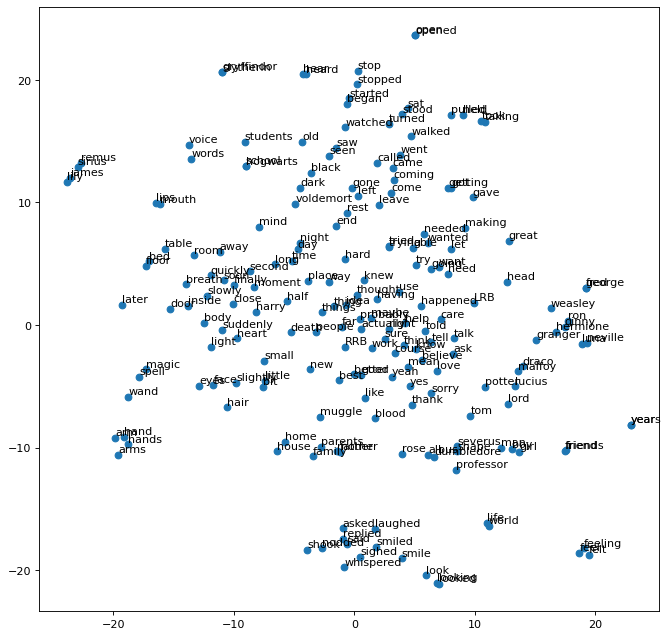

In [ ]:
Y = tsne.fit_transform(vectors[:200]).T
figure(figsize=(10, 10), dpi=80)
plt.scatter(Y[0], Y[1])
for i in range(len(Y[0])):
    plt.annotate(words[i], (Y[0][i], Y[1][i] + 0.2))
plt.show()

заметим, что семантически близкие слова образуют класстеры: например `[arms, hands, hand]`, `[home, house, parents, family]`, `[magic, spell, wand]`, `[came, coming, went, walked, leave]` и др.

визуализируем все 1000 слов без аннотации

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


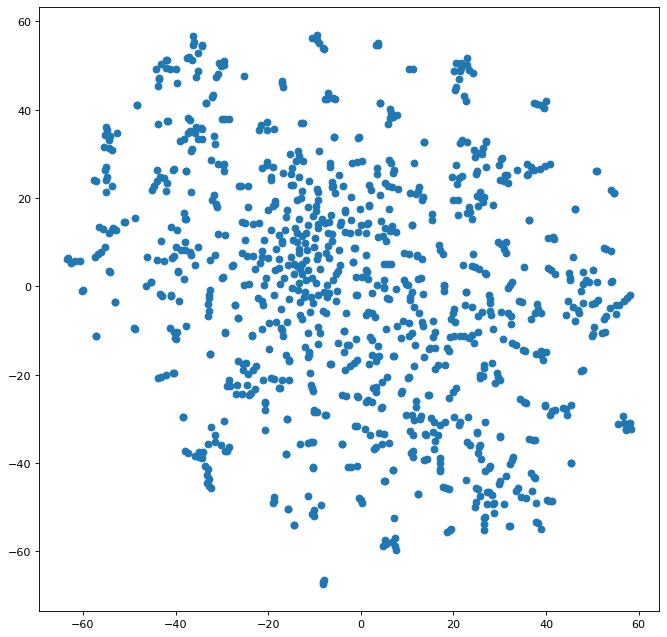

In [ ]:
Y = tsne.fit_transform(vectors).T
figure(figsize=(10, 10), dpi=80)
plt.scatter(Y[0], Y[1])
plt.show()

## Часть 3. [5 баллов] Классификация текстов
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro $F_1$.
Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов. 


1. [1 балл] Используйте fastText в качестве baseline-классификатора.

обучим эмбединги с помощью FastText

In [ ]:
embs = FastText(dataloader)

подготовим данные для обучения классификатора

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/hpac_corpus/hpac_training_128.tsv', sep = '\t', header = None)
df_test = pd.read_csv('/content/hpac_corpus/hpac_test_128.tsv', sep = '\t', header = None)
df_dev = pd.read_csv('/content/hpac_corpus/hpac_dev_128.tsv', sep = '\t', header = None)
df_train.head(5)

,0,1,2
0,7642954.0.676,RIDDIKULUS,were staring at her . she was up next to face ...
1,10443333.0.5753,RIDDIKULUS,"that whole time . her first reaction , for whi..."
2,4703706.0.8690,STUPEFY,we watched his inglorious withdrawal together ...
3,4593427.0.1815,ACCIO,"my wand , `` incendio . '' this wretched chill..."
4,4278446.0.2692,EXPELLIARMUS,"already compared ours , they 're the same ever..."


In [ ]:
def preprocess(text):
  text = any2unicode(text).lower()
  text = preprocess_string(text)
  return text

def get_dataset(df, id2label, max_length, feature_dim):
  dataset = []
  for i in tqdm(range(len(df))):
    label, text = df.iloc[i][1], df.iloc[i][2]
    tokenized = preprocess(text)
    vectors = np.zeros(shape=(MAX_LENGTH, FEATURE_DIM))
    for i in range(min(MAX_LENGTH, len(tokenized))):
      try:
        vectors[i] = embs.wv.get_vector(tokenized[i])
      except:
        pass

    label_id = id2label.index(label)
    dataset.append([vectors, label_id])
  return dataset

MAX_LENGTH = 128
FEATURE_DIM = 100

id2label = sorted(list(df_train[1].unique()))

train_dataset = get_dataset(df_train, id2label, MAX_LENGTH, FEATURE_DIM)
test_dataset = get_dataset(df_test, id2label, MAX_LENGTH, FEATURE_DIM)


X_train = [item[0].mean(axis=0) for item in train_dataset]
Y_train = [item[1] for item in train_dataset]

X_test = [item[0].mean(axis=0) for item in test_dataset]
Y_test = [item[1] for item in test_dataset]

в качестве классификатора будем использовать мультилинейный перцептрон

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, Y_train)

In [ ]:
Y_pred = clf.predict(X_test)
f1_score(Y_test, Y_pred, average='macro')

0.3734667103968514


2. [2 балла] Используйте сверточные  или реккурентные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать $k$-max pooling. 

в качестве эмбединггов мы будем использовать word2vec

In [ ]:
embs = Word2Vec(dataloader, size=128)

А в качестве классификатора -- свёрточную нейронную сеть. Определим класс свёрточной нейронной сети с помощью библиотеки PyTorch:

In [ ]:
class LanguageModel(nn.Module):
  def __init__(self, in_channels, out_channels, num_classes):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.dp = nn.Dropout(p=0.2)

    self.kernel_1 = 2
    self.kernel_2 = 3
    self.kernel_3 = 4
    self.kernel_4 = 5
    
    self.stride = 2

    self.conv_1 = nn.Conv1d(self.in_channels, self.out_channels, self.kernel_1, self.stride)
    self.conv_2 = nn.Conv1d(self.in_channels, self.out_channels, self.kernel_2, self.stride)
    self.conv_3 = nn.Conv1d(self.in_channels, self.out_channels, self.kernel_3, self.stride)
    self.conv_4 = nn.Conv1d(self.in_channels, self.out_channels, self.kernel_4, self.stride)

    self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
    self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
    self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
    self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)

    self.fc = Linear(2496 , num_classes)
  

  def forward(self, x):

      x1 = self.conv_1(x)
      x1 = torch.relu(x1)
      x1 = self.pool_1(x1)
      
      x2 = self.conv_2(x)
      x2 = torch.relu((x2))
      x2 = self.pool_2(x2)
   
      x3 = self.conv_3(x)
      x3 = torch.relu(x3)
      x3 = self.pool_3(x3)
      
      x4 = self.conv_4(x)
      x4 = torch.relu(x4)
      x4 = self.pool_4(x4)
      
      union = torch.cat((x1, x2, x3, x4), 2)
      union = union.reshape(union.size(0), -1)

      logits = self.fc(self.dp(union))
      return logits
  
  def count_parameters(self):
      return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, encoder, label_encoding):
        super().__init__()
        self.X = np.array([encoder.encode(text) for text in texts])
        self.Y = np.array([label_encoding.index(label) for label in labels])
        self.index = -1
        self.size = len(texts)

    def __len__(self):
        return self.size
    def __iter__(self):
        return self

    def __getitem__(self, index):
        return self.X[index].T, self.Y[index].T

    def __next__(self):
        self.index += 1
        if self.index < self.size:
            return self.X[self.index].T, self.Y[self.index]
        self.index = -1
        raise StopIteration

определим класс энкодера, задача которого переводит текст в векторное представление

In [ ]:
class Encoder:
  def __init__(self, model=None, max_length=84):
    self.max_length = max_length
    self.model = model
  
  def train(self, corpus):
    self.model = Word2Vec(corpus)
  
  def encode(self, text):
    result = np.zeros(shape=(self.max_length, self.model.vector_size))
    tokens = strip_short(strip_punctuation(remove_stopwords(text))).split()
    for i in range(len(tokens)):
      try:
        result[i] = self.model.wv.get_vector(tokens[i])
      except:
        pass
    return result

векторизуем тексты и получим датасеты

In [ ]:
encoder = Encoder(model)

id2label = sorted(list(df_train[1].unique()))
train_dataset = CustomDataset(df_train[2], df_train[1], encoder, id2label)
test_dataset = CustomDataset(df_test[2], df_test[1], encoder, id2label)

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

del train_dataset, test_dataset

for x,y in train_dataloader:
  break
print(x.shape)

torch.Size([64, 128, 84])


In [ ]:
lang_model = LanguageModel(128, 32, len(id2label))
lang_model.to('cuda')

LanguageModel(
  (dp): Dropout(p=0.2, inplace=False)
  (conv_1): Conv1d(128, 32, kernel_size=(2,), stride=(2,))
  (conv_2): Conv1d(128, 32, kernel_size=(3,), stride=(2,))
  (conv_3): Conv1d(128, 32, kernel_size=(4,), stride=(2,))
  (conv_4): Conv1d(128, 32, kernel_size=(5,), stride=(2,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_4): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2496, out_features=85, bias=True)
)

определим цикл обучения и обучим модель

In [ ]:
N_EPOCHS = 400

optimizer = optim.Adam(lang_model.parameters(), 0.0001)
criterion = nn.CrossEntropyLoss()

N, M = len(train_dataloader), len(test_dataloader)

for epoch in range(N_EPOCHS):
  epoch_loss = 0
  S = 0
  lang_model.train()
  for x,y in train_dataloader:
    x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()
    y_pred = lang_model(x.float())
    loss_value = criterion(y_pred, y)
    epoch_loss += loss_value.item()
    loss_value.backward()
    optimizer.step()
  if epoch % 10 == 0: 
    print(epoch, epoch_loss/N)

0 3.266141791158558
10 2.3752990027915017
20 2.0777562644023835
30 1.88427546354556
40 1.758653217948121
50 1.6587205012597668
60 1.5911637328228945
70 1.5256938882414466
80 1.4763880410824843
90 1.431065620492913
100 1.390580912139208
110 1.3602049154975107
120 1.3318154676138165
130 1.3050278402700755
140 1.2787692790766954
150 1.2626363713868893
160 1.245099479979508
170 1.222914545571066
180 1.2089022689451077
190 1.192871671095725
200 1.17735315025916
210 1.1597981641200006
220 1.1560030732800302
230 1.140925526181148
240 1.121609170439361
250 1.1170467564842008
260 1.1081461629362197
270 1.0960532732675359
280 1.0879804404434852
290 1.0859860132398536
300 1.076149951811227
310 1.0610117705896545
320 1.0608265568802264
330 1.0514665201603428
340 1.035752102060308
350 1.0367705201552273
360 1.03385900713089
370 1.0168793926959523
380 1.013718687443518
390 1.0142418109857774


протестируем модель с помощью F1 score

In [ ]:
from sklearn.metrics import f1_score

S = 0
M = len(test_dataset)
lang_model.eval()

Y_pred = []
Y_true = []

for x, y in tqdm(test_dataset):
    x, y = torch.tensor(x).unsqueeze(0).float(), torch.tensor(y).unsqueeze(0)
    logits = lang_model(x)
    y_pred = torch.argmax(logits)

    Y_pred += list(y_pred.numpy())
    Y_true += list(y.numpy())

100%|██████████| 7679/7679 [00:09<00:00, 816.56it/s]


In [ ]:
f1_score(Y_true, Y_pred, average='macro')

0.59354323332


Таким образом, качество CNN классификатора лучше чем мультилинейного классификатора.

3. [2 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

Список методов агументации в нашем случае сильно ограничен в силу того, что мы выполняем сильную предобработку: удаляем знаки пунктуации, переводим в нижний регистр, удаляем стоп слова. Наиболее обнадеживающим методов остается замена слов на их синонимы. Выполним эту агументацию с помощью библиотеки `nltk`.

In [ ]:
# скачиваем WordNet
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

К сожалению, многие слова являются многозначными и, следовательно, имеют различные по смыслу синонимы. Например, слово "cat" имеет минимум три смысла: 1) An animal of the family Felidae 2) A spiteful or angry woman 3) An enthusiast or player of jazz. Очевидно, что каждого смысла будут сильнр различные между собой слова. 

Автоматическая проверка корректности синонимов - это отдельная проблема. В рамках нашей задачи мы ограничемся наиболее частоиспользуемым смыслов слова. В wordnet такие смыслы обычно представлены самым первым синсетом.

In [ ]:
def get_synonym(word):
  sns = wn.synsets(word)
  for i in range(len(sns)):
    for j in range(len(sns[i].lemma_names())):
      candidate = sns[i].lemma_names()[j]
      if word != candidate:
        return candidate
  return word

def rephrase(tokens):
  result = []
  for token in tokens:
    result.append(get_synonym(token))
  return result
      

In [ ]:
get_synonym('interest')

'involvement'

Давайте проверим, как работает wordnet на целых предложениях:

In [ ]:
def preprocess(text):
  return strip_short(strip_punctuation(remove_stopwords(text))).split()

text = "I was interested in wonderful vibe of the city"
tokens = preprocess(text)
text_augmented = rephrase(tokens)
print(f'before: {tokens}')
print(f'after: {text_augmented}')

before: ['interested', 'wonderful', 'vibe', 'city']
after: ['interest', 'fantastic', 'vibration', 'metropolis']


Наконец, применим данную функцию к корпусу с помощью модифицированного класса `DataLoader`: с заданной вероятностью мы будем применять аугментацию:

In [ ]:
class DataLoader:
    def __init__(self, dir, aug_func, aug_prob):
        self.dir = dir
        self.filenames = [filename for filename in os.listdir(dir)]
        self.index = -1
        self.size = len(self.filenames)
        self.aug_func = aug_func
        self.aug_prob = aug_prob

    def __iter__(self):
        return self

    def __next__(self):
        self.index += 1
        if self.index % 3000 == 0:
          print(f"[{self.index}/{self.size}]")
        if self.index < self.size:
            with open(self.dir + self.filenames[self.index], 'r') as f:
              tokenized_text = strip_short(strip_punctuation(remove_stopwords(f.read()))).split()
            
            if choice([0, 1], p=[self.prob, 1-self.prob]) == 0:
              tokenized_text = rephrase(tokenized_text)
            
            return tokenized_text
        self.index = -1
        raise StopIteration

повторим процедуру обучения пайплайна на аугментированных данных:

1) обучим эмбеддинги с помощью Word2Vec

2) обучим CNN классификатор 

In [ ]:
dataloader = DataLoader("/content/hpac_source/", rephrase, 0.5)
embs = Word2Vec(dataloader, size=128, iter=10)

In [ ]:
encoder = Encoder(model)

id2label = sorted(list(df_train[1].unique()))
train_dataset = CustomDataset(df_train[2], df_train[1], encoder, id2label)
test_dataset = CustomDataset(df_test[2], df_test[1], encoder, id2label)

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

del train_dataset, test_dataset

for x,y in train_dataloader:
  break
print(x.shape)

In [ ]:
lang_model = LanguageModel(128, 32, len(id2label))
lang_model.to('cuda')

In [ ]:
N_EPOCHS = 400

optimizer = optim.Adam(lang_model.parameters(), 0.0001)
criterion = nn.CrossEntropyLoss()

N, M = len(train_dataloader), len(test_dataloader)

for epoch in range(N_EPOCHS):
  epoch_loss = 0
  S = 0
  lang_model.train()
  for x,y in train_dataloader:
    x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()
    y_pred = lang_model(x.float())
    loss_value = criterion(y_pred, y)
    epoch_loss += loss_value.item()
    loss_value.backward()
    optimizer.step()
  if epoch % 10 == 0: 
    print(epoch, epoch_loss/N)

0 3.266141791158558
10 2.943990027913243
20 2.434362644122223
30 2.084275463545232
40 1.958653217948122
50 1.8872050125324668
60 1.7323637342425945
70 1.6256938882414466
80 1.6763880410824843
90 1.531065620492913
100 1.500580912139208
110 1.4602323233975107
120 1.4318153213213323
130 1.4050278402700755
140 1.401769279323231
150 1.3726363713868893
160 1.345099479979508
170 1.332914545571066
180 1.3300022689451077
190 1.331871671095725
200 1.32735315025916
210 1.3197981641200006
220 1.2760030732800302
230 1.2602222226181148
240 1.261609170439361
250 1.2270467564842008
260 1.2181461629362197
270 1.2060532732675359
280 1.1979804404434852
290 1.1859860132398536
300 1.176149951811227
310 1.1610117705896545
320 1.1608265434343434
330 1.1514665201603428
340 1.135752102060308
350 1.1367705201552273
360 1.13385900713089
370 1.0168793926959523
380 1.033718687443518
390 1.0342418109857774


In [ ]:
from sklearn.metrics import f1_score

S = 0
M = len(test_dataset)
lang_model.eval()

Y_pred = []
Y_true = []

for x, y in tqdm(test_dataset):
    x, y = torch.tensor(x).unsqueeze(0).float(), torch.tensor(y).unsqueeze(0)
    logits = lang_model(x)
    y_pred = torch.argmax(logits)

    Y_pred += list(y_pred.numpy())
    Y_true += list(y.numpy())

In [ ]:
f1_score(Y_true, Y_pred, average='macro')

0.58959459495


Таким образом, агументация за счет синонимов на оказала эначительного эффекта на качество модели. Нам представляется, что это вызвано неаккуратной автоматической подборкой синонимов с помощью wordnet. Однако вопрос качества автоматической подборки синонимов является сложным и представляет интерес сам по себе.  

Часть 4. [1 балл] Итоги
Напишите краткое резюме проделанной работы. Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?

В рамкой данной работы был выполнен ряд задач, связанных с моделированием языка. 

Во-первых, был использован метод Word2Vec для построения семантического векторного пространства на основе корпуса "Harry Potter and the Action Prediction Challenge"; полученная языковая модель успешно справляется с задачи нахождения похожих слов и аналогий. Во-вторых, была выполнена визуализация полученного методом Word2Vec семантического пространства с помощью метода нелинейного проецирования t-SNE. В-третьих, была решена задача классификация текста с помощью мультилинейного перцептрона, где векторы текстов были получены с помощью усреднения векторов слов, полученных методом FastText; качество такого классификатора составляет 0.39 macro F1 score. В-четвертых, был реализована сверточная нейронная сеть для задачи классификации; качество такого классификатора составляет 0.59 macro F1 score. Наконец, исходные данные были агументированы с помощью подбора синонимов. Обучение на аугментированных данных не позволило улучшить качество классификации.

В силу ограниченности вычислительных мощностей и малого количества времени, нам не удалось проверить все поставленные нами гипотезы. Например, нами выдвигалась гипотеза о том, что RNN модель будем справляться с задачей лучше, кроме того, была гипотеза о том, что аугментация текста методом перестановки слов сможет улучшить качество классификации.